In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:  tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:  print(e)

from PIL import Image
import numpy as np
import h5py
import matplotlib.pyplot as plt
import json
import cv2

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

2024-09-29 23:02:03.980232: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 23:02:03.980249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 23:02:03.980260: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/necphy/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape the data to add an extra dimension (for grayscale channel)
train_images = train_images.reshape(train_images.shape[0], 1, 28, 28)
test_images = test_images.reshape(test_images.shape[0], 1, 28, 28)

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [3]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, n_in, n_out, activation=None):
        super(CustomDense, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Initialize weights and bias
        self.w = self.add_weight(shape=(self.n_in, self.n_out), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.n_out,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        z = tf.matmul(inputs, self.w) + self.b  
        if self.activation:
            z = self.activation(z)  
        return z  
    
    
class CustomFlatten(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomFlatten, self).__init__()

    def call(self, inputs):
        return tf.reshape(inputs, [tf.shape(inputs)[0], -1])

In [18]:
tf.keras.backend.clear_session()
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(1, 28, 28), use_bias=False, data_format='channels_first'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, data_format='channels_first'))

model.add(layers.Conv2D(64, (3, 3), use_bias=False, data_format='channels_first'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, data_format='channels_first'))

model.add(CustomFlatten())

model.add(CustomDense(n_in=64*5*5, n_out=10)) 
model.add(layers.Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 26, 26)        288       
                                                                 
 activation (Activation)     (None, 32, 26, 26)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 13, 13)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 11, 11)        18432     
                                                                 
 activation_1 (Activation)   (None, 64, 11, 11)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 5, 5)          0         
 g2D)                                                   

In [19]:
model.fit(train_images, train_labels, batch_size=128, epochs=5, validation_data=(test_images, test_labels))

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')

Epoch 1/5


469/469 [==============================] - 1s 1ms/step - loss: 0.2706 - accuracy: 0.9235 - val_loss: 0.0731 - val_accuracy: 0.9786
Epoch 2/5
469/469 [==============================] - 0s 1ms/step - loss: 0.0756 - accuracy: 0.9772 - val_loss: 0.0614 - val_accuracy: 0.9812
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0556 - accuracy: 0.9827 - val_loss: 0.0448 - val_accuracy: 0.9844
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0453 - accuracy: 0.9856 - val_loss: 0.0430 - val_accuracy: 0.9857
Epoch 5/5
469/469 [==============================] - 0s 1ms/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 0.0444 - val_accuracy: 0.9857
313/313 - 0s - loss: 0.0444 - accuracy: 0.9857 - 193ms/epoch - 615us/step
Test accuracy: 0.9857


# Save trained weight into `txt` format.

In [20]:
PATH_WEIGHT_FOLDER = r"weight"

weights = model.get_weights()
print(len(weights))

for weight in weights:
    print(f"weight shape: {weight.shape}")  

4
weight shape: (3, 3, 1, 32)
weight shape: (3, 3, 32, 64)
weight shape: (1600, 10)
weight shape: (10,)


In [26]:
conv_weight = tf.transpose(weights[0], perm=[3, 2, 0, 1]).numpy()
np.savetxt(os.path.join(PATH_WEIGHT_FOLDER, 'conv2d_weights.txt'), conv_weight.flatten(), fmt='%f', delimiter=' ')

conv_1_weight = tf.transpose(weights[1], perm=[3, 2, 0, 1]).numpy()
np.savetxt(os.path.join(PATH_WEIGHT_FOLDER, 'conv2d_1_weights.txt'), conv_1_weight.flatten(), fmt='%f', delimiter=' ')

np.savetxt(os.path.join(PATH_WEIGHT_FOLDER, 'dense_weights.txt'), weights[2].flatten(), fmt='%f', delimiter=' ')
np.savetxt(os.path.join(PATH_WEIGHT_FOLDER, 'dense_bias.txt'), weights[3], fmt='%f', delimiter=' ')

print("Weights and biases saved to separate .txt files.")

Weights and biases saved to separate .txt files.


# Run prediction

(28, 28)


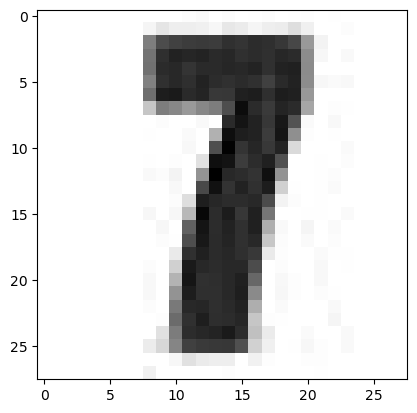

In [29]:
img_path = 'image/digit_gray.jpg'

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = np.array(img)
print(img.shape)

plt.imshow(img, cmap='gray')

In [30]:
# Normalize the pixel values to [0, 1]
img_normalized = img.astype('float32') / 255.0

img_input = np.reshape(img_normalized, (1, 1, 28, 28))

predicted_proba = model.predict(img_input, verbose=0)

# Print the predicted probabilities for each class (digits 0-9)
print("Predicted probabilities:", predicted_proba)
predicted_digit = np.argmax(predicted_proba)
print(f"Predicted digit: {predicted_digit}")
print(f"Predicted digit probability: {predicted_proba[0][predicted_digit]}")

Predicted probabilities: [[1.4144456e-02 2.7578779e-02 8.3968640e-05 8.0715420e-11 9.1218239e-01
  6.4961128e-08 3.1494787e-05 4.5977071e-02 1.6956728e-06 6.7734014e-08]]
Predicted digit: 4
Predicted digit probability: 0.9121823906898499


## Get output of Conv

In [ ]:
layer_name = 'activation'
conv2d_layer = model.get_layer(name=layer_name)

intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=conv2d_layer.output)

# Get the output of the 'conv2d' layer
conv2d_output = intermediate_model.predict(img_input)

# Display the shape of the output tensor
print("Shape of 'conv2d' layer output:", conv2d_output.shape)

In [ ]:
print(conv2d_output.flatten()[:100])

In [ ]:
conv2d_output.shape

# Get output Flatten

In [ ]:
layer_name = 'custom_flatten'
flatten_layer = model.get_layer(name=layer_name)

intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=flatten_layer.output)

flatten_output = intermediate_model.predict(img_input)

# Display the shape of the output tensor
print("Shape of 'flatten_output' layer output:", flatten_output.shape)

In [ ]:
print(flatten_output.flatten()[0:100])

## Get output of FC

In [ ]:
layer_name = 'custom_dense'
dense_layer = model.get_layer(name=layer_name)

intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=dense_layer.output)

# Get the output of the 'conv2d' layer 
dense_output = intermediate_model.predict(img_input)

# Display the shape of the output tensor
print("Shape of 'dense' layer output:", dense_output.shape)